# Library Import

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# data preprocessing
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re
from collections import Counter
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
# Model Building
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Import data

In [2]:
data = pd.read_csv("spam.csv",encoding='latin1')
data.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
761,ham,"We are at grandmas. Oh dear, u still ill? I fe...",NaN,NaN,NaN
3420,spam,Welcome! Please reply with your AGE and GENDER...,NaN,NaN,NaN
65,spam,"As a valued customer, I am pleased to advise y...",NaN,NaN,NaN
610,spam,22 days to kick off! For Euro2004 U will be ke...,NaN,NaN,NaN
3435,ham,If india win or level series means this is rec...,NaN,NaN,NaN


# Drop unwanted columns

In [3]:
data.drop(columns = ["Unnamed: 2","Unnamed: 3","Unnamed: 4"], inplace = True)
data.head(5)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Rename columns

In [4]:
data.rename(columns = {"v1":'result', 'v2':'emails'}, inplace = True)

# Returns number of NaN values in columns

In [5]:
data.isnull().sum()

result    0
emails    0
dtype: int64

# Returns number of duplicates

In [6]:
data.duplicated().sum()

403

# Drops duplicates keeping first occurences

In [7]:
data = data.drop_duplicates(keep='first')

In [8]:
data.shape

(5169, 2)

In [9]:
data.head(5)

,result,emails
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Number of spam/ham emails

In [10]:
data['result'].value_counts()

result
ham     4516
spam     653
Name: count, dtype: int64

# Pie-chart

([<matplotlib.patches.Wedge at 0x2aed36ae860>,
 [Text(-1.0144997251399075, 0.4251944351600247, 'ham'),
  Text(1.014499764949479, -0.4251943401757036, 'spam')],
 [Text(-0.5533634864399495, 0.23192423736001344, '87.4%'),
  Text(0.5533635081542612, -0.23192418555038377, '12.6%')])

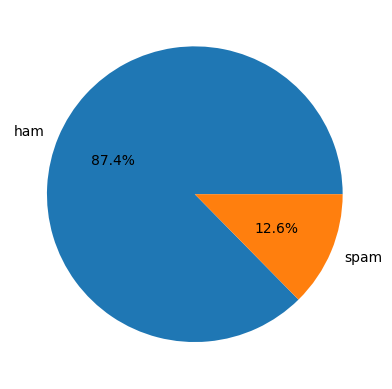

In [11]:
plt.pie(data['result'].value_counts(),labels = data['result'].value_counts().index, autopct='%1.1f%%')

# EDA (email length, no. of words, sentences)

In [12]:
data['Length'] = data['emails'].apply(len)
data['num_words'] = data['emails'].apply(word_tokenize).apply(len)
data['num_sentence'] = data['emails'].apply(sent_tokenize).apply(len)
data.head(2)

,result,emails,Length,num_words,num_sentence
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2
1,ham,Ok lar... Joking wif u oni...,29,8,2


In [13]:
avg_length_spam = data[data['result'] == 'spam']['Length'].mean()
avg_length_ham = data[data['result'] == 'ham']['Length'].mean()
avg_word_spam = data[data['result'] == 'spam']['num_words'].mean()
avg_word_ham = data[data['result'] == 'ham']['num_words'].mean()
avg_sent_spam = data[data['result'] == 'spam']['num_sentence'].mean()
avg_sent_ham = data[data['result'] == 'ham']['num_sentence'].mean()

# Bar-graphs (avg length, word, sentences)

Average Length of Spam Emails: 137.89127105666157
Average Length of Ham Emails: 70.45925597874225


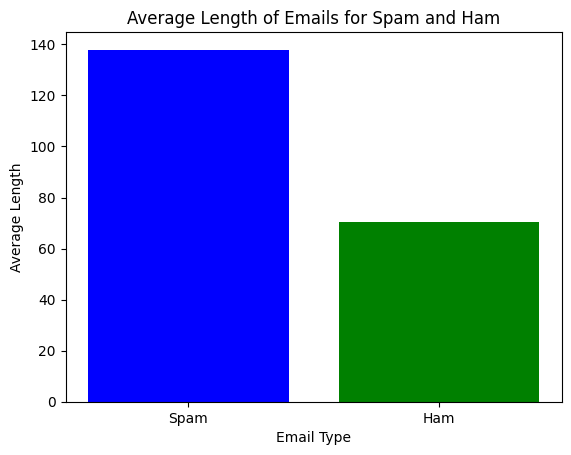

In [14]:
#plotting
print("Average Length of Spam Emails:", avg_length_spam)
print("Average Length of Ham Emails:", avg_length_ham)
plt.bar(['Spam', 'Ham'], [avg_length_spam, avg_length_ham], color=['Blue', 'green'])
plt.title('Average Length of Emails for Spam and Ham')
plt.xlabel('Email Type')
plt.ylabel('Average Length')
plt.show()

Average Word of Spam Emails: 27.6676875957121
Average Word of Ham Emails: 17.12378210806023


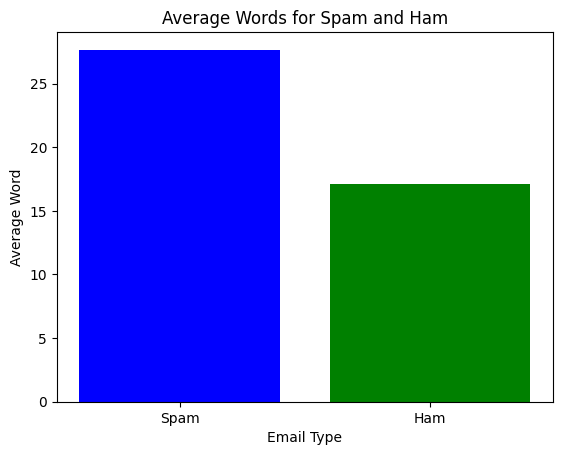

In [15]:
print("Average Word of Spam Emails:", avg_word_spam)
print("Average Word of Ham Emails:", avg_word_ham)
plt.bar(['Spam', 'Ham'], [avg_word_spam, avg_word_ham], color=['blue', 'green'])
plt.title('Average Words for Spam and Ham')
plt.xlabel('Email Type')
plt.ylabel('Average Word')
plt.show()

Average Sentences of Spam Emails: 2.970903522205207
Average Sentences of Ham Emails: 1.8201948627103632


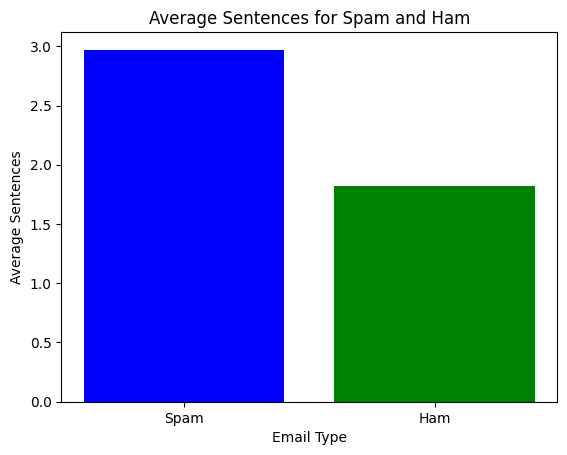

In [16]:
print("Average Sentences of Spam Emails:", avg_sent_spam)
print("Average Sentences of Ham Emails:", avg_sent_ham)
plt.bar(['Spam', 'Ham'], [avg_sent_spam, avg_sent_ham], color=['blue', 'green'])
plt.title('Average Sentences for Spam and Ham')
plt.xlabel('Email Type')
plt.ylabel('Average Sentences')
plt.show()

# Correlation between length and spam

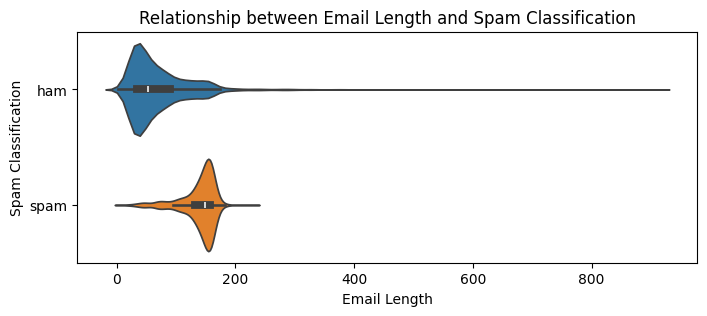

In [20]:
correlation = data['Length'].corr((data['result']=='spam').astype(int))
plt.figure(figsize=(8,3))
sns.violinplot(data=data, x='Length', y='result', hue='result')
plt.xlabel('Email Length')
plt.ylabel('Spam Classification')
plt.title('Relationship between Email Length and Spam Classification')
plt.show()